Reference: Coursera Project: Amazon Echo Reviews Sentiment Analysis Using NLP. <br>
Data source: smile-annotations-final.csv
https://www.kaggle.com/datasets/ashkhagan/smile-twitter-emotion-dataset

### Task : Explanatory data analysis and preprocessing

In [1]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
#Read data
df = pd.read_csv("Data/smile_annotations_final.csv",
                names = ['id', 'text', 'category'])
df.set_index('id', inplace = True)

In [3]:
df.head()

,text,category
id,,
6.118570e+17,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
6.144850e+17,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
6.147470e+17,@SelectShowcase @Tate_StIves ... Replace with ...,happy
6.148780e+17,@Sofabsports thank you for following me back. ...,happy
6.119320e+17,@britishmuseum @TudorHistory What a beautiful ...,happy


In [4]:
df.text.iloc[0]

'@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap'

In [5]:
df.category.value_counts()

category
nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: count, dtype: int64

### Re-label values

In [6]:
#Removing values with two or more labels with a pipe sign (|)
df = df[~df.category.str.contains('\|')]

In [7]:
df.category.value_counts()

category
nocode          1572
happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
disgust            6
Name: count, dtype: int64

In [8]:
#Removing labels with 'nocode'
df = df[df.category !='nocode']

In [9]:
df.category.value_counts()

category
happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
disgust            6
Name: count, dtype: int64

In [10]:
#Creating categories of the labels
possible_labels = df.category.unique()

In [11]:
possible_labels

array(['happy', 'not-relevant', 'angry', 'disgust', 'sad', 'surprise'],
      dtype=object)

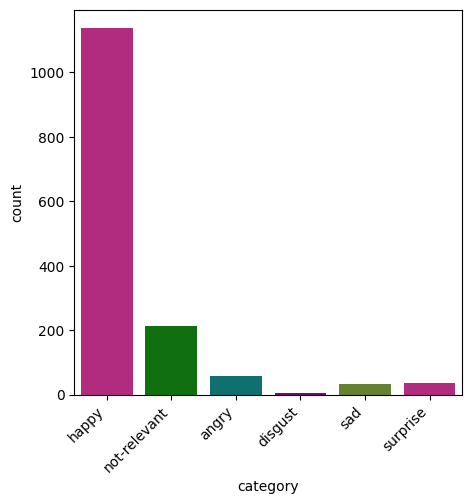

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the bar chart


fig, ax = plt.subplots(figsize = (5, 5))
colors = ['#C71585', '#008000', '#008080', '#800080', '#6B8E23']

count_plot = sns.countplot(x = df['category'], ax = ax, palette = colors)
count_plot.set_xticklabels(count_plot.get_xticklabels(), rotation = 45, ha = 'right')

# Display the bar chart
plt.show()

In [13]:
label_dict = {}
for index, possible_labels in enumerate(possible_labels):
    label_dict[possible_labels] = index

In [14]:
print(label_dict)

{'happy': 0, 'not-relevant': 1, 'angry': 2, 'disgust': 3, 'sad': 4, 'surprise': 5}


In [15]:
df['label']=df.category.replace(label_dict)

In [16]:
df.label.values

array([0, 0, 0, ..., 0, 0, 1])

In [17]:
df.index.values

array([6.14485e+17, 6.14747e+17, 6.14878e+17, ..., 6.13679e+17,
       6.15247e+17, 6.13016e+17])

### Plot the Wordcloud

In [71]:
#Create a list containing all the reviews 

sentences_all = df['category'].tolist()
#sentences_all

In [72]:
#sentences join all reviews
sentences_as_one_string = ' '.join(sentences_all)
#sentences_as_one_string

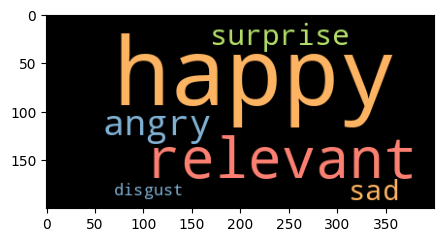

In [75]:
from wordcloud import WordCloud

#Plot WordCloud with positive reviews
plt.figure(figsize = (5, 10))
custom_color = 'Set3'
plt.imshow(WordCloud(colormap = custom_color).generate(sentences_as_one_string))

### Training/Validation split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    df.index.values,
    df.label.values,
    test_size = 0.15,
    random_state =17, #works as seed
    stratify = df.label.values
)

In [20]:
X_train.size
X_val.size
y_train.size
y_val.size

223

In [21]:
#Create a new variable called 'data type' with 'not set' values
df['data_type'] = ['not_set']*df.shape[0]

#few other ways to create a new variable with a specific value in it
#df['data_type'] = 'not_set'
#df.assign(data_type = 'not_set')

In [22]:
df.head()

,text,category,label,data_type
id,,,,
6.144850e+17,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0,not_set
6.147470e+17,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0,not_set
6.148780e+17,@Sofabsports thank you for following me back. ...,happy,0,not_set
6.119320e+17,@britishmuseum @TudorHistory What a beautiful ...,happy,0,not_set
6.115700e+17,@NationalGallery @ThePoldarkian I have always ...,happy,0,not_set


In [23]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] ='val'

In [24]:
df.groupby(['category', 'label', 'data_type']).count()

text
category     label data_type      
angry        2     train        41
                   val          16
disgust      3     train         5
                   val           1
happy        0     train       888
                   val         249
not-relevant 1     train       169
                   val          45
sad          4     train        24
                   val           8
surprise     5     train        27
                   val           8

### Task : Loading Tokenizer and Encoding Data

In [25]:
!pip install transformers

from transformers import BertTokenizer
from torch.utils.data import TensorDataset 

In [26]:
from transformers import pipeline

unmasker = pipeline('fill-mask', model='bert-base-uncased')

unmasker("Hello I'm a [MASK] model.")

2023-11-07 12:18:14.606497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.10731089860200882,
  'token': 4827,
  'token_str': 'fashion',
  'sequence': "hello i'm a fashion model."},
 {'score': 0.08774486929178238,
  'token': 2535,
  'token_str': 'role',
  'sequence': "hello i'm a role model."},
 {'score': 0.0533839650452137,
  'token': 2047,
  'token_str': 'new',
  'sequence': "hello i'm a new model."},
 {'score': 0.04667220264673233,
  'token': 3565,
  'token_str': 'super',
  'sequence': "hello i'm a super model."},
 {'score': 0.027095893397927284,
  'token': 2986,
  'token_str': 'fine',
  'sequence': "hello i'm a fine model."}]

In [27]:
#pip install transformers

#from transformers import BertTokenizer, BertModel
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#model = BertModel.from_pretrained("bert-base-uncased")
#text = "Replace me by any text you'd like."
#encoded_input = tokenizer(text, return_tensors='pt')
#output = model(**encoded_input)


In [28]:
#!huggingface-cli login

In [29]:
#pip install -U huggingface_hub

In [30]:
#If this code does not run: sign in on huggingface and get a token to run the model 

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                        do_lower_case = True)

In [31]:
# prepare data for input into a BERT transformer model 
# The encoded_data_train will be used into the model during the training phase

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type == 'train'].text.values,
    add_special_tokens = True,
    return_attention_mask = True,
    pad_to_max_length = True,
    truncation=True,
    max_length = 256,
    return_tensors = 'pt'
)


# prepare validation data for BERT transformer model 
# The encoded_data_val dictionary will be used to feed the validation data into the model during the validation phase
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type == 'val'].text.values,
    add_special_tokens = True,
    return_attention_mask = True,
    pad_to_max_length = True,
    truncation=True,
    max_length = 256,
    return_tensors = 'pt'
)




/Users/farzanayasmin/miniconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [32]:
#label_values_train = df[df.data_type == 'train'].label.astype(int).values
#labels_train = torch.tensor(label_values_train, dtype=torch.long)

In [33]:
# Preparing the inputs and labels for the training process
# The model will be trained to map the input_ids to the correct labels, using the attention_mask to ignore padded tokens
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].label.values)

In [34]:
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, 
                              attention_masks_val, labels_val)

In [ ]:
# This code is an example of how TensorDataset works

from torch.utils.data import TensorDataset, DataLoader
import torch

# Suppose we have some features and labels as tensors
features = torch.tensor([[1, 2], [3, 4], [5, 6]], dtype=torch.float32)
labels = torch.tensor([0, 1, 0], dtype=torch.long)

# Create the TensorDataset
dataset = TensorDataset(features, labels)

# Now we can index the dataset
single_data_point = dataset[0]

# Create a DataLoader for batching, etc.
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Use the DataLoader in a training loop
for batch in dataloader:
    batch_features, batch_labels = batch

for i, data in enumerate(dataset):
    print(f"Index {i}: Features - {data[0]}, Label - {data[1]}")

In [35]:
len(dataset_train)
#len(dataset_val)

1154

### Task : Setting up BERT Pretrained Model

In [36]:
from transformers import BertForSequenceClassification

In [37]:
#Importing BERT model

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = len(label_dict),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Task : Creating Data Loaders

In [38]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [39]:
batch_size = 4
dataloader_train = DataLoader(
    dataset_train,
    sampler = RandomSampler(dataset_train),
    batch_size = batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler = RandomSampler(dataset_val),
    batch_size = 32
)

### Task : Setting up Optimizer and Scheduler

In [40]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [41]:
optimizer = AdamW(
    model.parameters(),
    lr = 1e-5,    #2e-5 > 5e-5; hyperparameter
    eps = 1e-8
)

/Users/farzanayasmin/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [42]:
epochs = 4 #10
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps= len(dataloader_train)*epochs
)

### Task : Defining our Performence Matrics

In [43]:
import numpy as np

In [44]:
from sklearn.metrics import f1_score

In [45]:
#Predictions are probabilities

#preds = [0.9 0.05 0.05 0 0 0]
#preds = [1 0 0 0 0 0]

In [46]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [47]:
#Create performence matrix to check the accuracy

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v : k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds == label])}/{len(y_true)}/n')

### Task : Creating our Training Loop

In [48]:
#Create seed
 
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val) #Ffor GPU 

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cpu


In [50]:
def evaluate(dataloader_val):
    
    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]
                 }
        
        with torch.no_grad():
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
    loss_val_avg = loss_val_total/len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis = 0)
    true_vals = np.concatenate(true_vals, axis = 0)
    
    return loss_val_avg, predictions, true_vals
        

In [51]:
#The value of epochs is 10
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train,
                       desc = 'Epoch {:1d}'.format(epoch),
                       leave = False,
                        disable = False)
    for batch in progress_bar:
        
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids'      : batch[0],
            'attention_mask' : batch[1],
            'labels'         : batch[2]
        }
        
        outputs = model(**inputs) #unpacks dictionary straight into the output
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
    #torch.save(model.state_dict(), f'Models/BERT_ft_epoch{epoch}.model')
    
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/289 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7747814141304126


  0%|          | 0/11 [00:00<?, ?it/s]

Validation loss: 0.6264678944240917
F1 Score (weighted): 0.7421678450664936


Epoch 2:   0%|          | 0/289 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.4969610962017752


  0%|          | 0/11 [00:00<?, ?it/s]

Validation loss: 0.6526627383110198
F1 Score (weighted): 0.7607767929646332


Epoch 3:   0%|          | 0/289 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.36671260512791654


  0%|          | 0/11 [00:00<?, ?it/s]

Validation loss: 0.6641176424243234
F1 Score (weighted): 0.7928734358078008


Epoch 4:   0%|          | 0/289 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.29763175136728737


  0%|          | 0/11 [00:00<?, ?it/s]

Validation loss: 0.6865144236521288
F1 Score (weighted): 0.7917563388092357


### Model Evaluation

In [52]:
outputs.loss

tensor(1.6476, grad_fn=<NllLossBackward0>)

In [53]:
outputs.logits

tensor([[-1.4480,  1.2317,  1.4610, -0.7689, -0.6127,  0.2141],
        [-0.3154,  2.6152,  0.1252, -1.9468, -0.7121, -0.5602]],
       grad_fn=<AddmmBackward0>)

In [54]:
model.to(device)
pass

In [ ]:
#If I run my model using GPU
#model.load_state_dict(
#    torch.load('Models/finetuned_bert_epoch_1_gpu_trained.model',
#              map_location = torch.device('cpu'))
#)

In [55]:
_, prediction, true_vals = evaluate(dataloader_val)

  0%|          | 0/11 [00:00<?, ?it/s]

In [56]:
#get accuracy score
accuracy_per_class(prediction, true_vals)

Class: happy
Accuracy: 241/249/n
Class: not-relevant
Accuracy: 21/45/n
Class: angry
Accuracy: 6/16/n
Class: disgust
Accuracy: 0/1/n
Class: sad
Accuracy: 0/8/n
Class: surprise
Accuracy: 0/8/n


In [57]:
import torch.nn.functional as F

logits = torch.tensor([[-1.4480, 1.2317, 1.4610, -0.7689, -0.6127, 0.2141],
                       [-0.3154, 2.6152, 0.1252, -1.9468, -0.7121, -0.5602]])

# Apply softmax to convert logits to probabilities
probabilities = F.softmax(logits, dim=1)

print(probabilities)

tensor([[0.0230, 0.3354, 0.4219, 0.0454, 0.0530, 0.1212],
        [0.0436, 0.8167, 0.0677, 0.0085, 0.0293, 0.0341]])
